# Acemoglu-Chernozhukov-Werning-Winston model

The **Acheww** model. Let's just write it down and then simulate the dynamics.

The basic equations of the model are three age groups:

$$
S_j(t)+I_j(t)+R_j(t)+D_j(t)=N_j
$$

We have $\sum N_j = 1$. The matching function has a denomiator that vanishes when $\alpha=2$. For $\alpha=1$, it resembles the harmonic matching function and allows for interference of $R$ types in the matching between $S$ and $I$. 

$$
M_j = \left(\sum_k\beta_{jk}\left[(S_k+\eta_kI_k+(1-\kappa_k)R_k)(1-\theta_jL_k)+\kappa_kR_k\right]\right)^{\alpha-2}
$$

$$
\dot{I}_j = M_j(S,I,R,L)(1-\theta_jL_j)S_j\sum_k\beta_{jk}(1-\theta_kL_k)I_k - \gamma_jI_j
$$


Description of parameters:

$\eta$ is the fraction of infected individuals of age $k$ that are capable of infecting others. $\theta_k$ is the degree of societal lockdown. While $L_k$ is also included as a lockdown variable. I'm going to program this so we have a maximum lockdown and then a "taper off." 

Anyways, here is a table:

| Parameter   |                    Description                                    | Continuous Value |
|-----------  |     :--------------------:                                        | :-----: | 
|$\theta_k$   | Policy compliance rate   |    .75     |
|$\rho_{jk}$  | The natural rate at which group $j$ and $k$ interact.             |    .2     |
|$\iota_k$    | ICU care rate among group $j$                              |                |
|$\gamma_k$   | Recovery rate of non-hospitalized cases.                          |    1/18=.0555     |
|$\delta^d_k$ | Death rate of group $k$ hospitalized cases. ACWW assume $\delta^r_k = \gamma_k-\delta^d_k$. | (.001, .01, .06)*1/18   |
|$\phi_k$     | Detection rate among ICU cases, due to testing.   |
|$\tau_k$     | Detection rate among non-ICU cases. |
|$\kappa_k$   | Cases that have recovered that can return to work. |

Parameters obey the following rules:

$$
\beta_{jk}=\rho_{jk}(1-\iota_k\phi_k-(1-\iota_k)\tau_k)
$$

$$
\eta_k = 1-\iota_k\phi_k - (1-\iota_k)\tau_k
$$

$$
i_{1t+1} = i_{1t}(1-\iota_{1}(\delta_1^r+(1-\delta_1^r)\psi_1(h_t))-(1-\iota_1)\gamma_1) + m_1(1-\theta_1l_{1t})s_{1t}\sum_{k}(\beta_{1k}(1-\theta_{k}l_{kt})i_{kt}
$$
$$
i_{2t+1} = i_{2t}(1-\iota_{2}(\delta_2^r+(1-\delta_2^r)\psi_2(h_t))-(1-\iota_2)\gamma_2) + m_2(1-\theta_2l_{2t})s_{2t}\sum_{k}(\beta_{2k}(1-\theta_{k}l_{kt})i_{kt}
$$
$$
i_{3t+1} = i_{3t}(1-\iota_{3}(\delta_3^r+(1-\delta_2^r)\psi_3(h_t))-(1-\iota_3)\gamma_3) + m_3(1-\theta_3l_{3t})s_{3t}\sum_{k}(\beta_{3k}(1-\theta_{k}l_{kt})i_{kt}
$$

$\beta$ should be a matrix that has to be made square. 

Susceptibles obey:

$$
s_{1t+1} = s_{1t} - m_1(1-\theta_1l_{1t})s_{1t}\sum_{k}(\beta_{1k}(1-\theta_{k}l_{kt})i_{kt}
$$
$$
s_{2t+1} = s_{2t} - m_2(1-\theta_2l_{2t})s_{2t}\sum_{k}(\beta_{2k}(1-\theta_{k}l_{kt})i_{kt}
$$
$$
s_{3t+1} = s_{3t} - m_3(1-\theta_3l_{3t})s_{3t}\sum_{k}(\beta_{3k}(1-\theta_{k}l_{kt})i_{kt}
$$


Deaths:


$$
d_{1t+1} = d_{1t} + \delta_{1t}^di_{1t}
$$
$$
d_{2t+1} = d_{2t} - \delta_{2t}^di_{2t}
$$
$$
d_{3t+1} = d_{3t} - \delta_{3t}^di_{3t}
$$

Recoveries:

$$
r_{1t+1} = r_{1t} + \delta_{1t}^ri_{1t}
$$
$$
r_{2t+1} = r_{2t} + \delta_{2t}^ri_{2t}
$$
$$
r_{3t+1} = r_{3t} + \delta_{3t}^ri_{3t}
$$

How to program? Let's start with a base version of the model that does not have a "lockdown" policy. So, here we are omitting the variables $l_i$. I still retain the $\theta$ variables because we can see how this works as we move along.


# Optimal policies

To approximate the optimal policies derived by the authors, they typically have a shape where

- A strict lockdown tapers off over time
- Comparison of targeted versus untargeted lockdown
- Question of how testing and isolation can impact things. 
- Role of matching technology as well...

We need to calibrate the parameters and for this I will use the following - we can use a discretized version of their model where things are calculated by day. So, they have the population frequencies matching age groups as $N_1=.53, N_2=.26, N_3=.21$. We will suppose that patient zero is $N_m=.01$. 

They use a wage which is set to $w=1$ for all age groups except the old, for whom $w=0$. We have left out their $L$ variable, but it is $.7$ whenever there is a lock down. This would go under our $\theta$ parameter. 

They start with $\phi_j=\tau_j=0$ so this is a no-testing regime. $\kappa_j=1$ at the beginning.

A daily value of $\gamma=1/18$ is used. This translates to a discrete daily value of $1-e^{-\gamma}=p=.054$ in discrete time. They set $\rho=.2$, which comes out as $.181$ in a discrete model. They allege this matches estimates of $R_0$ for Covid. This is common for everyone, by the way. 

Daily mortality rates are $.001, .01, and .06$, all divided by 18. In discrete terms, these would be: $.0000555, $.00555$, and $.00333$, respectively.

Typical lockdown variables push $L=.7$, but can also be put to $L=1$ for a certain group, so this will reduce social interactions by 70 percent I guess. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [53]:
def achewwmodel(s0=[.53, .25, .21], i0=[0, .01, 0], rho=[[.2, .2, .2], [.2, .2, .2], [.2, .2, .2]], 
                theta=[.5, .5, .5], taper=[0.0,0.0,0.0], L=[0, 0, 0], delay=0, sigma=40, 
                gamma=[0.054, 0.054, 0.054], tau=[0, 0, 0], phi=[0, 0, 0], kappa = [1, 1, 1], 
                dd=[0.000555, 0.00555, 0.00333], alpha=2, its=5000, tol=.001):
    
    '''This function simulates the ACHEWW model approximately. One should put in the maximal values of 
       the lockdown parameters theta, and then allow for taper (which functions like a rate of depreciation)
       after that. Additional policy parameters
       are static in that we suppose there is a fixed policy about isolation/detection/release. Taper can
       also be specific to age group, note.'''
    
    iota = [sigma*deathrate for deathrate in dd]
    
    eta = [1 - iota[0]*phi[0] - (1 - iota[0])*tau[0] ,
           1 - iota[1]*phi[1] - (1 - iota[1])*tau[1] ,
           1 - iota[2]*phi[2] - (1 - iota[2])*tau[2] ]
    
    beta = [[r*eta[0] for r in rho[0]],
            [r*eta[1] for r in rho[1]],
            [r*eta[2] for r in rho[2]] ]
    
    S1 = []
    S2 = []
    S3 = []

    I1 = []
    I2 = []
    I3 = []
    
    R1 = []
    R2 = []
    R3 = []
    
    H1 = []
    H2 = []
    H3 = []
    
    D1 = []
    D2 = []
    D3 = []
    
    L1 = []
    L2 = []
    L3 = []
    
    s1, s2, s3 = s0[0], s0[1], s0[2]
    i1, i2, i3 = i0[0], i0[1], i0[2]
    r1, r2, r3 = 0, 0, 0
    d1, d2, d3 = 0, 0, 0
    
    t=0
    
    i = i1 + i2 + i3
    
    while t<its and i> tol: 
        
        if t <  delay:
            la = [0, 0, 0]
        else:
            la = [1, 1, 1]
        
        l = [(lla*LLa)*(1-tape)**t for lla, LLa, tape in zip (la, L, taper)]
        L1.append(l[0])
        L2.append(l[1])
        L3.append(l[2])
        
        m1 = ( beta[0][0]*((s1 + eta[0]*i1 + (1-kappa[0])*r1)*(1 - l[0]*theta[0]) + kappa[0]*r1) + 
               beta[0][1]*((s2 + eta[1]*i2 + (1-kappa[1])*r2)*(1 - l[1]*theta[1]) + kappa[1]*r2) +
               beta[0][2]*((s3 + eta[2]*i3 + (1-kappa[2])*r3)*(1 - l[2]*theta[2]) + kappa[2]*r3)   )**(alpha - 2)
        m2 = ( beta[1][0]*((s1 + eta[0]*i1 + (1-kappa[0])*r1)*(1 - l[0]*theta[0]) + kappa[0]*r1) +
               beta[1][1]*((s2 + eta[1]*i2 + (1-kappa[1])*r2)*(1 - l[1]*theta[1]) + kappa[1]*r2) +
               beta[1][2]*((s3 + eta[2]*i3 + (1-kappa[2])*r3)*(1 - l[2]*theta[2]) + kappa[2]*r3)   )**(alpha - 2)
        m3 = ( beta[2][0]*((s1 + eta[0]*i1 + (1-kappa[0])*r1)*(1 - l[0]*theta[0]) + kappa[0]*r1) +
               beta[2][1]*((s2 + eta[1]*i2 + (1-kappa[1])*r2)*(1 - l[1]*theta[1]) + kappa[1]*r2) +
               beta[2][2]*((s3 + eta[2]*i3 + (1-kappa[2])*r3)*(1 - l[2]*theta[2]) + kappa[2]*r3)   )**(alpha - 2)
        
        num1 = (1 - l[0]*theta[0])*s1*( beta[0][0]*i1*(1 - l[0]*theta[0]) + beta[0][1]*i2*(1 - l[1]*theta[1]) + 
               beta[0][2]*i3*(1 - l[2]*theta[2])    )
        num2 = (1 - l[1]*theta[1])*s2*( beta[1][0]*i1*(1 - l[0]*theta[0]) + beta[1][1]*i2*(1 - l[1]*theta[1]) + 
               beta[1][2]*i3*(1 - l[2]*theta[2])    )
        num3 = (1 - l[2]*theta[2])*s3*( beta[2][0]*i1*(1 - l[0]*theta[0]) + beta[2][1]*i2*(1 - l[1]*theta[1]) + 
               beta[2][2]*i3*(1 - l[2]*theta[2])    )
        
        # Before next-period values let's compute statics like hospitalizations and all that
        # Current hospitalizations
        
        h1 = iota[0]*i1
        h2 = iota[1]*i2
        h3 = iota[2]*i3
        
        h = h1 + h2 + h3
        
        psi  = 3*[None]
        psi[0] = 4*dd[0]*(1 + dd[0]*i1 + dd[1]*i2 + dd[2]*i3)
        psi[1] = 4*dd[1]*(1 + dd[0]*i1 + dd[1]*i2 + dd[2]*i3)
        psi[2] = 4*dd[2]*(1 + dd[0]*i1 + dd[1]*i2 + dd[2]*i3)
        
        dr = [gam / (1-ps) for (gam, ps) in zip (gamma, psi)]
        
        i1p = i1 - i1*(1 - iota[0])*gamma[0] - h1*(psi[0] + (1-psi[0])*dr[0]) + m1*num1
        i2p = i2 - i2*(1 - iota[1])*gamma[1] - h2*(psi[1] + (1-psi[1])*dr[1]) + m2*num2
        i3p = i3 - i3*(1 - iota[2])*gamma[2] - h3*(psi[2] + (1-psi[2])*dr[2]) + m3*num3
        
        s1p = s1 - m1*num1
        s2p = s2 - m2*num2
        s3p = s3 - m3*num3

        r1p = r1 + i1*iota[0]*dr[0] + (1 - iota[0])*gamma[0]*i1 
        r2p = r2 + i2*iota[1]*dr[1] + (1 - iota[1])*gamma[1]*i2
        r3p = r3 + i3*iota[2]*dr[2] + (1 - iota[2])*gamma[2]*i3

        d1p = d1 + h1*(1-dr[0])*psi[0]
        d2p = d2 + h2*(1-dr[1])*psi[1]
        d3p = d3 + h3*(1-dr[2])*psi[2] 
        
        S1.append(s1p)
        S2.append(s2p)
        S3.append(s3p)

        I1.append(i1p)
        I2.append(i2p)
        I3.append(i3p)

        R1.append(r1p)
        R2.append(r2p)
        R3.append(r3p)

        D1.append(d1p)
        D2.append(d2p)
        D3.append(d3p)
        
        H1.append(h1)
        H2.append(h2)
        H3.append(h3)
        
        s1 = s1p
        s2 = s2p
        s3 = s3p

        i1 = i1p
        i2 = i2p
        i3 = i3p

        r1 = r1p
        r2 = r2p
        r3 = r3p

        d1 = d1p
        d2 = d2p
        d3 = d3p
        
        i = i1p + i2p + i3p
        t += 1
        
    return({'S':{'s1':S1, 's2':S2, 's3':S3}, 'I':{'i1':I1, 'i2':I2, 'i3':I3},
            'R':{'r1':R1, 'r2':R2, 'r3':R3}, 'D':{'d1':D1, 'd2':D2, 'd3':D3}, 
            'H':{'h1':H1, 'h2':H2, 'h3':H3}, 'L':{'l1':L1, 'l2':L2, 'l3':L3}})  

In [54]:
res = achewwmodel()
resp = achewwmodel(L=[.5, .5, .5], taper=[.01, .01, .01])

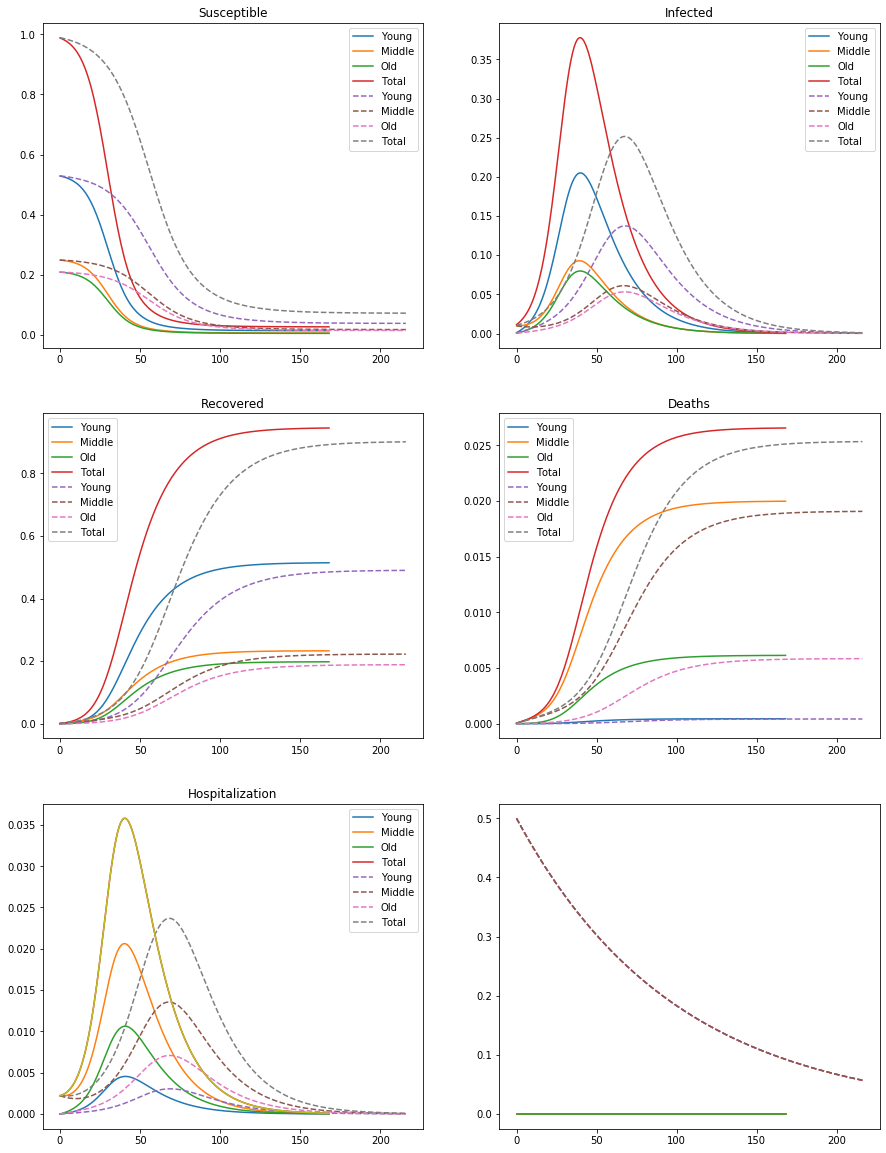

In [55]:
fig = plt.figure(figsize=(15, 12))

axs = fig.add_subplot(3, 2, 1)
adj = fig.subplots_adjust(bottom=-.4)
xr  = np.arange(len(res['S']['s1']))
ls1 = axs.plot(xr, res['S']['s1'])
ls2 = axs.plot(xr, res['S']['s2'])
ls3 = axs.plot(xr, res['S']['s3'])

stotal = [s1 + s2 + s3 for s1, s2, s3 in zip(res['S']['s1'] , res['S']['s2'], res['S']['s3'])]

lst = axs.plot(xr, stotal)

xrp  = np.arange(len(resp['S']['s1']))
ls1p = axs.plot(xrp, resp['S']['s1'], linestyle='--')
ls2p = axs.plot(xrp, resp['S']['s2'], linestyle='--')
ls3p = axs.plot(xrp, resp['S']['s3'], linestyle='--')

stotalp = [s1 + s2 + s3 for s1, s2, s3 in zip(resp['S']['s1'] , resp['S']['s2'], resp['S']['s3'])]

lstp = axs.plot(xrp, stotalp, linestyle='--')

sla = axs.legend(['Young', 'Middle', 'Old', 'Total', 'Young', 'Middle', 'Old', 'Total'])
stit = axs.title.set_text('Susceptible')

axi = fig.add_subplot(3, 2, 2)

xr  = np.arange(len(res['I']['i1']))
li1 = axi.plot(xr, res['I']['i1'])
li2 = axi.plot(xr, res['I']['i2'])
li3 = axi.plot(xr, res['I']['i3'])

itotal = [i1 + i2 + i3 for i1, i2, i3 in zip(res['I']['i1'] , res['I']['i2'], res['I']['i3'])]

lst = axi.plot(xr, itotal)

xrp  = np.arange(len(resp['I']['i1']))
li1p = axi.plot(xrp, resp['I']['i1'], linestyle='--')
li2p = axi.plot(xrp, resp['I']['i2'], linestyle='--')
li3p = axi.plot(xrp, resp['I']['i3'], linestyle='--')

itotalp = [i1 + i2 + i3 for i1, i2, i3 in zip(resp['I']['i1'] , resp['I']['i2'], resp['I']['i3'])]

lstp = axi.plot(xrp, itotalp, linestyle='--')

ila = axi.legend(['Young', 'Middle', 'Old', 'Total', 'Young', 'Middle', 'Old', 'Total'])
itit = axi.title.set_text('Infected')

axr = fig.add_subplot(3, 2, 3)

xr  = np.arange(len(res['R']['r1']))
lr1 = axr.plot(xr, res['R']['r1'])
lr2 = axr.plot(xr, res['R']['r2'])
lr3 = axr.plot(xr, res['R']['r3'])

rtotal = [r1 + r2 + r3 for r1, r2, r3 in zip(res['R']['r1'] , res['R']['r2'], res['R']['r3'])]

lst = axr.plot(xr, rtotal)

xrp  = np.arange(len(resp['R']['r1']))
lr1p = axr.plot(xrp, resp['R']['r1'], linestyle='--')
lr2p = axr.plot(xrp, resp['R']['r2'], linestyle='--')
lr3p = axr.plot(xrp, resp['R']['r3'], linestyle='--')

rtotalp = [r1 + r2 + r3 for r1, r2, r3 in zip(resp['R']['r1'] , resp['R']['r2'], resp['R']['r3'])]

lst = axr.plot(xrp, rtotalp, linestyle='--')

rla = axr.legend(['Young', 'Middle', 'Old', 'Total', 'Young', 'Middle', 'Old', 'Total'])
rtit = axr.title.set_text('Recovered')

axd = fig.add_subplot(3, 2, 4)

xr  = np.arange(len(res['D']['d1']))
ld1 = axd.plot(xr, res['D']['d1'])
ld2 = axd.plot(xr, res['D']['d2'])
ld3 = axd.plot(xr, res['D']['d3'])

dtotal = [d1 + d2 + d3 for d1, d2, d3 in zip(res['D']['d1'] , res['D']['d2'], res['D']['d3'])]

lst = axd.plot(xr, dtotal)

xrp  = np.arange(len(resp['D']['d1']))
ld1p = axd.plot(xrp, resp['D']['d1'], linestyle='--')
ld2p = axd.plot(xrp, resp['D']['d2'], linestyle='--')
ld3p = axd.plot(xrp, resp['D']['d3'], linestyle='--')

dtotalp = [d1 + d2 + d3 for d1, d2, d3 in zip(resp['D']['d1'] , resp['D']['d2'], resp['D']['d3'])]

lst = axd.plot(xrp, dtotalp, linestyle='--')

rla = axd.legend(['Young', 'Middle', 'Old', 'Total', 'Young', 'Middle', 'Old', 'Total'])
rtit = axd.title.set_text('Deaths')

axh = fig.add_subplot(3, 2, 5)

xr  = np.arange(len(res['H']['h1']))
ld1 = axh.plot(xr, res['H']['h1'])
ld2 = axh.plot(xr, res['H']['h2'])
ld3 = axh.plot(xr, res['H']['h3'])

htotal = [h1 + h2 + h3 for h1, h2, h3 in zip(res['H']['h1'] , res['H']['h2'], res['H']['h3'])]

lst = axh.plot(xr, htotal)

xrp  = np.arange(len(resp['H']['h1']))
ld1p = axh.plot(xrp, resp['H']['h1'], linestyle='--')
ld2p = axh.plot(xrp, resp['H']['h2'], linestyle='--')
ld3p = axh.plot(xrp, resp['H']['h3'], linestyle='--')

htotalp = [h1 + h2 + h3 for h1, h2, h3 in zip(resp['H']['h1'] , resp['H']['h2'], resp['H']['h3'])]

lst = axh.plot(xrp, htotalp, linestyle='--')

rla = axh.legend(['Young', 'Middle', 'Old', 'Total', 'Young', 'Middle', 'Old', 'Total'])

rtit = axh.title.set_text('Hospitalization')

axpol = fig.add_subplot(3, 2, 6)

xr  = np.arange(len(res['L']['l1']))
ld1 = axpol.plot(xr, res['L']['l1'])
ld2 = axpol.plot(xr, res['L']['l2'])
ld3 = axpol.plot(xr, res['L']['l3'])

lst = axh.plot(xr, htotal)

xrp  = np.arange(len(resp['L']['l1']))
ld1p = axpol.plot(xrp, resp['L']['l1'], linestyle='--')
ld2p = axpol.plot(xrp, resp['L']['l2'], linestyle='--')
ld3p = axpol.plot(xrp, resp['L']['l3'], linestyle='--')

